In [123]:
#| default_exp benchmark

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
!pip install -e ../

Obtaining file:///Users/dhritimansagar/Dev/dog_breed_id
  Preparing metadata (setup.py) ... done
  Attempting uninstall: dog_breed_id
    Found existing installation: dog_breed_id 0.0.1
    Uninstalling dog_breed_id-0.0.1:
      Successfully uninstalled dog_breed_id-0.0.1
  Running setup.py develop for dog_breed_id


In [124]:
#| export
from dog_breed_id.data_preprocessing import read_csv_with_array_columns
from dog_breed_id.research import get_classes_from_frame
from miniai.learner import *
from miniai.init import *
from miniai.activations import *
from miniai.datasets import show_images

import cv2
import fastcore.all as fc
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
from matplotlib import pyplot as plt

import shutil
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torcheval.metrics import MulticlassAccuracy
from sklearn.model_selection import train_test_split
import timm

In [125]:
df = read_csv_with_array_columns('../data/dogs.csv', ['bboxes'])

In [126]:
def get_data_subsets(df, cache_path='../data', recreate=False):
    Path(cache_path).mkdir(parents=True, exist_ok=True)
    if not Path('../data/train.csv').exists() or recreate:
        train_subset, valid_subset = train_test_split(df, train_size=0.1, test_size=0.01, stratify=df['category'])
        valid_subset, test_subset = train_test_split(valid_subset, train_size=0.5, test_size=0.5)
        train_subset.to_csv('../data/train.csv')
        valid_subset.to_csv('../data/valid.csv')
        test_subset.to_csv('../data/test.csv')
    else:
        print('Cached files found, reading from disk')
        train_subset = read_csv_with_array_columns('../data/train.csv', ['bboxes'])
        valid_subset = read_csv_with_array_columns('../data/valid.csv', ['bboxes'])
        test_subset = read_csv_with_array_columns('../data/test.csv', ['bboxes'])
    return train_subset, valid_subset, test_subset

In [127]:
train_subset, valid_subset, test_subset = get_data_subsets(df)

Cached files found, reading from disk


In [128]:
#| export

def get_id_mappings(df, include_background=True):
    classes = get_classes_from_frame(df, include_background)
    label2id = {label: i for i, label in enumerate(classes)}
    id2label = {i: label for i, label in enumerate(classes)}
    return label2id, id2label

class DogBreedClassificationDataset(Dataset):
    def __init__(self, df, transforms=None):
        super(DogBreedClassificationDataset, self).__init__()
        self.df = df
        if not transforms:
            self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transforms = transforms
        self.label2id, self.id2label = get_id_mappings(self.df, include_background=False)
    
    def __len__(self):
        return df.shape[0]

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = Image.open(item.image)
        tensor = self.transforms(img)
        label = self.label2id[item['category']]
        return tensor, label

TRAIN_TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(0.5, 0.5, 0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomErasing(p=0.1),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
VALID_TRANSFORMS = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [162]:
train_ds = DogBreedClassificationDataset(train_subset, TRAIN_TRANSFORMS)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)

valid_ds = DogBreedClassificationDataset(valid_subset, VALID_TRANSFORMS)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=128)

test_ds = DogBreedClassificationDataset(test_subset, VALID_TRANSFORMS),
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [163]:
#| export
from functools import partial
iw = partial(init_weights, leaky=0.1)
def freeze_weights(p):
    p.requires_grad_(False)

def init_model(model, initialize=False):
    if initialize:
        model.apply(iw)
    model.apply(freeze_weights)
    model.fc.requires_grad_(True)

In [164]:
astats = ActivationStats(fc.risinstance(torch.nn.ReLU))
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [165]:
#| export
from collections import namedtuple

DataLoaders = namedtuple('DataLoaders', ['train', 'valid'])

In [166]:
dls = DataLoaders(train_dl, valid_dl)

## Exploring ResNet

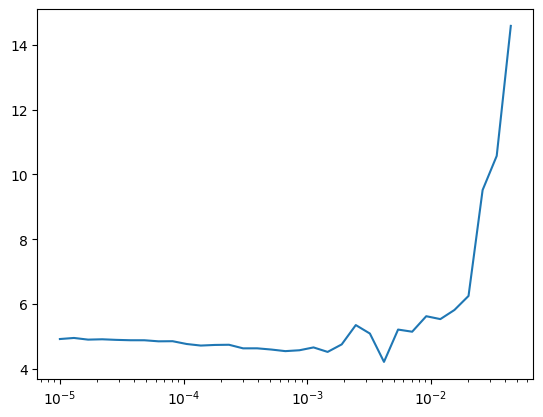

In [167]:
model = timm.create_model('resnet101', num_classes=137)
init_model(model)
TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=DeviceCB(), opt_func=torch.optim.Adam).lr_find()

In [168]:
params = []
for p in model.parameters():
    if p.requires_grad:
        params.append(p)
print(len(params))

2


In [169]:
model = timm.create_model('resnet101', num_classes=137)
init_model(model)
learner = TrainLearner(model, dls=dls, loss_func=torch.nn.CrossEntropyLoss(), cbs=cbs, opt_func=torch.optim.Adam)

In [170]:
learner.fit(n_epochs=10, lr=0.001)

KeyboardInterrupt: 

In [172]:
print(DeviceCB().device)

mps


In [173]:
#| hide
import nbdev; nbdev.nbdev_export()